In [1]:
import numpy as np
import cvxpy as cvx

from scipy.spatial import distance
import matplotlib.pyplot as plt

import cupy as cp
%matplotlib inline

import itertools

In [2]:
print("CuPy version:", cp.__version__)

print("CUDA available" if cp.is_available() else "CUDA not available, only CPU")

CuPy version: 6.5.0
CUDA available


In [3]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 5)

# Simple two-marginal problem

In [4]:
n = 200
m1 = 70

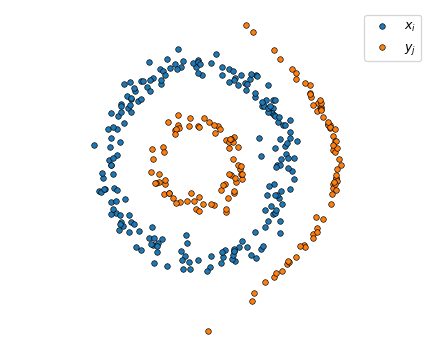

In [5]:
x = np.random.randn(n) * 1.5 * np.pi
x = (1.7 * np.stack([np.cos(x), 1.1*np.sin(x)], axis=1)
     + 0.15 * np.random.randn(n, 2))

thet_y = np.random.randn(m1) * 0.9 * np.pi
y = (0.8 * np.stack([np.cos(thet_y), np.sin(thet_y)], axis=1) 
     + 0.1 * np.random.randn(m1, 2))

m2 = 70
m = m1 + m2
y2 = np.zeros((m2, 2))
y2[m2//2:, 1] = 1.2 + 0.8 * np.random.randn(m2//2)
y2[:m2//2, 1] = -1. + np.random.randn(m2//2)
y2[:, 0] = -0.3 * np.abs(y2[:, 1]) ** 1.8 + 2.7 + 0.05 * np.random.randn(m2)
y = np.vstack((y, y2))

plt.scatter(*x.T, label="$x_i$", s=20, edgecolors='k', linewidths=.5)
plt.scatter(*y.T, label="$y_j$", s=20, edgecolors='k', linewidths=.5)
plt.axis('off')
plt.axis('equal')
plt.legend();

The cost matrix is given by
\\[
    \mathbf{C}_{i,j} = |x_i - y_j|^2
\\]

In [6]:
# the distance matrix
cost_mat = np.square(distance.cdist(x, y, metric='euclidean'))

Between the two datasets $X$ and $Y$, the Wasserstein distance is given by
$$
    \mathcal W_2^2(\mathbf a,\mathbf b) = \min_{\mathbf{P}: \mathbf P^T\mathbf 1 = \mathbf a,\;\mathbf P\mathbf 1 = \mathbf b}~\langle \mathbf P,\mathbf C\rangle
$$

Here, the mass assigned to each point is identical. The obvious solution is taking the nearest-neighbor mapping between the points of $X$ and $Y$.

The Kantorovitch dual problem is given by
$$
    \max_{(\mathbf f,\mathbf g)\in R(\mathbf C)}~ \langle \mathbf f,\mathbf a\rangle+\langle\mathbf g,\mathbf b\rangle
$$
where $R(\mathbf C) = \{ \mathbf f,\mathbf g : \mathbf 1\mathbf f^T + \mathbf g \mathbf 1^T \leq \mathbf C \}$

## Sinkhorn

Define the Gibbs matrix
$$
    \mathbf K_{i,j} = \exp(-\mathbf C_{i,j}/\epsilon)
$$

Then the Sinkhorn iterations are given by:
$$
    \mathbf u^{(n+1)} = \frac{\mathbf a}{\mathbf K\mathbf v^{(n)}},
    \quad
    \mathbf v^{(n+1)} = \frac{\mathbf b}{\mathbf K^T\mathbf u^{(n+1)}}
$$

In [7]:
def sinkhorn(a, b, K, n_iters=100, verbose=1):
    r"""
    verbose: detail level of the Sinkhorn run
    """
    # Initialize whether to use Numpy/CuPy
    xp = cp.get_array_module(a)
    v = xp.ones_like(b)
    
    for i in range(n_iters):
        u_tmp = a / (K.dot(v))
        v_tmp = b / (xp.dot(K.T, u_tmp))
        
        if verbose==2 or (verbose==1 and i+1==n_iters):
            du_norm = xp.linalg.norm(u-u_tmp)
            dv_norm = xp.linalg.norm(v-v_tmp)
            print("Rel. L2 improvement: u (%.3e); v (%.3e)"
                  % (du_norm/xp.linalg.norm(u),
                     dv_norm/xp.linalg.norm(v)))
        u = u_tmp
        v = v_tmp
    u = u[:, None]
    v = v[:, None]
    P = u * K * v.T
    err_u = xp.linalg.norm(a - xp.sum(P, axis=1), ord=1)
    err_v = xp.linalg.norm(b - xp.sum(P, axis=0), ord=1)
    print("Marginal constraint violation -- u: %.3e | v: %.3e"
          % (xp.log(err_u), xp.log(err_v)))
    return P, (u, v)

In [8]:
eps = 4e-3
K_mat = np.exp(-cost_mat / eps)

a_mes = np.ones(n) / n
b_mes = np.ones(m) / m

In [9]:
if cp.is_available():
    K_mat = cp.asarray(K_mat)
    a_mes = cp.asarray(a_mes)
    b_mes = cp.asarray(b_mes)

In [10]:
plan, (u, v) = sinkhorn(a_mes, b_mes, K_mat, n_iters=100)

Rel. L2 improvement: u (nan); v (2.258e+00)
Marginal constraint violation -- u: -6.170e-01 | v: -3.674e+01


We check the type of this array:

In [11]:
# Convert to Numpy array
if isinstance(plan, cp.ndarray):
    plan = cp.asnumpy(plan)

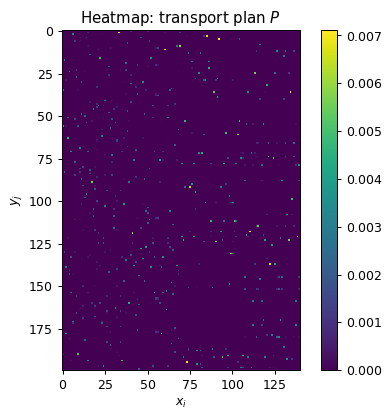

In [13]:
plt.imshow(plan, interpolation="nearest")
plt.xlabel("$x_i$")
plt.ylabel("$y_j$")
plt.title(r"Heatmap: transport plan $P$")
plt.colorbar();

In [14]:
plan_max = plan.max()
threshold = 0.05 * plan_max

index_set = np.argwhere(plan > threshold)

In [14]:
scatter_opts = {
    "s": 16
}

fig = plt.figure()

plt.scatter(*x.T, marker="o", s=15)
plt.scatter(*y.T, marker="o", s=15)

plt.legend(["Sources $X$", "Targets $Y$"])

for i,j in index_set:
    alph = (plan[i, j] / plan_max) ** (1/3)
    plt.plot([x[i,0], y[j, 0]], [x[i,1], y[j, 1]],
             color='black', zorder=-1,
             ls='--', linewidth=1.2 * alph, alpha=alph)

plt.axis('off')
plt.axis('equal')
plt.title("Entropic OT plan $P$ (param. $\epsilon=%.1e$)" % eps);

In [15]:
fig.savefig("/home/manifold/Pictures/transport_sinkhorn_test2.png")

# Towards multimarginal transport: three measure case

In [134]:
n = 30
m = 25
p = 25

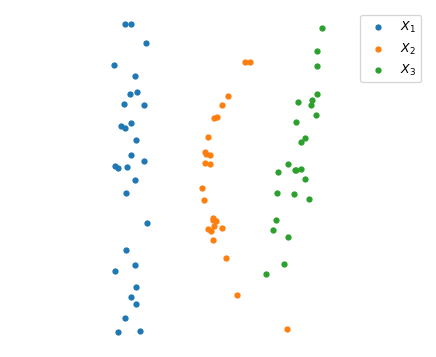

In [137]:
x = np.stack([0.1 + 0.24 * np.random.randn(n),
              (2 * np.random.rand(n) - 1) * 3.5], axis=1)

thet_ = (0.1 * np.random.randn(m) + 1.) * np.pi
y = 3.8 * np.stack([np.cos(thet_), np.sin(thet_)],axis=1)
y[:, 0] += 5.5 + 0.07* np.random.randn(m)

rz = np.random.randn(p)
z = np.stack([3.5 + 0.2 * np.random.randn(p) + 0.2 * rz,
              1.2 * rz], axis=1)

plt.scatter(*x.T, **scatter_opts)
plt.scatter(*y.T, **scatter_opts)
plt.scatter(*z.T, **scatter_opts)
plt.legend(["$X_1$", "$X_2$", "$X_3$"])
plt.axis('equal')
plt.axis('off');

We want to perform transport between three measures $\boldsymbol \mu_i$, $i=1,2,3$.

Given a cost matrix $\mathbf C = (\mathbf C_{i,j,k})$, we want to find $\mathbf P \in \mathbb R^{n_1\times n_2\times n_3}$ solving
$$
    \min_{\mathbf P}~ \langle \mathbf P, \mathbf C\rangle
$$
under the constraint that the sum of $\mathbf P$ along its axes $(0,2)$ is $\boldsymbol \mu_1$, etc.

Here the dot product is defined intuitively as
$$
    \langle\mathbf P,\mathbf C\rangle =
    \sum_{k=1}^3 \sum_{i_k = 1}^{n_k}
    \mathbf P_{i_1,i_2,i_3} \mathbf C_{i_1,i_2,i_3}
$$

For our first application we will use the total Euclidean distance from left-to-right
$$
    \mathbf C_{i,j,k} = |x_{1,i} - x_{2,j}|^2 + |x_{2,j} - x_{3,k}|^2 +
    \kappa|x_{1,i} - x_{3,k}|^2
$$
where $\kappa$ is big so as to penalize transport that skips the middle dataset.

Given $\epsilon > 0$, the associated Gibbs kernel can be factorized as a product of kernels
$$
    \mathbf{K}_{i,j,k} = \exp(-\mathbf C_{i,j,k}/\epsilon) =
    \mathbf K^1_{i,j}\mathbf K^2_{j,k}\mathbf K^3_{i,k}.
$$
which could speed up computations.

In [138]:
cost_mat = np.zeros((n, m, p))
print("Full cost matrix shape:", cost_mat.shape)

cost_mat1 = distance.cdist(x, y) ** 2
cost_mat1 = np.expand_dims(cost_mat1, 2)
print("1:", cost_mat1.shape)

cost_mat2 = distance.cdist(y, z) ** 2
cost_mat2 = np.expand_dims(cost_mat2, 0)
print("2:", cost_mat2.shape)

cost_mat3 = distance.cdist(x, z) ** 2
cost_mat3 = np.expand_dims(cost_mat3, 1)
print("3:", cost_mat3.shape)

Full cost matrix shape: (30, 25, 25)
1: (30, 25, 1)
2: (1, 25, 25)
3: (30, 1, 25)


In [139]:
kappa = 1.5
cost_mat[:] = cost_mat1 + cost_mat2 + kappa * cost_mat3

In [140]:
mus_ = mu1, mu2, mu3 = [np.ones(s)/s for s in [n, m, p]]

The adapted Sinkhorn algorithm reads
$$
    \mathbf u_{j, i_j} \leftarrow
    \frac{
        \boldsymbol \mu_{j,i_j}
    }{
        S_j(\tilde g)
    }
$$
where for $j=1,\ldots,3$
$$
    S_j(\gamma) = \sum_{\substack{1\leq i_k\leq n_k\\ k\neq j}}^{n_k}\gamma_{i}
$$
is the pushforward to the $j$-th marginal and the kernel $\tilde g$ is defined by the re-weighted outer product
$$
    \tilde g_i = K_i\prod_{k=1}^3 \mathbf u_{k,i_k} \in
    \mathbb R^{n_1\times n_2\times n_3}
$$

For stability we will be performing the updates in log-scale.
$$
    \mathbf a_{j,i_j} \leftarrow
    \log(\boldsymbol\mu_{j,i_j}) - \log\left(S_j(\tilde g)\right)
$$

In [141]:
old_np_setts = np.seterr(divide='raise')

In [142]:
class ThreeMargSinkhorn:
    r"""
    Sinkhorn algorithm for transport between three measures
    `mu_1`, `mu_2` and `mu_3`.
    """
    def __init__(self, mu1, mu2, mu3, cost: np.ndarray, eps=1e-1):
        self.mu1 = mu1
        self.mu2 = mu2
        self.mu3 = mu3
        self.cost = cost
        self.eps = eps
        
        # Compute the Gibbs matrix
        self.K_log = -self.cost / eps
        self.K = np.exp(self.K_log)
        print("Gibbs matrix shape:", self.K.shape)
    
    def compute(self, n_iter=100):
        u3 = 1e-4 + np.zeros_like(self.mu3)
        u2 = 1e-4 + np.zeros_like(self.mu2)
        u1 = 1e-4 + np.zeros_like(self.mu1)
        K = self.K_log
        gtilde = np.zeros_like(K) + 1e-5
        
        for n in range(n_iter):
            # outer product
            gtilde[:] = K + np.add.outer(
                np.add.outer(u1, u2), u3)
            Sj = np.sum(np.exp(gtilde), axis=(1, 2))
            u1[:] = np.log(self.mu1) - np.log(Sj)
            
            gtilde[:] = K + np.add.outer(
                np.add.outer(u1, u2), u3)
            Sj = np.sum(np.exp(gtilde), axis=(0, 2))
            u2[:] = np.log(self.mu2) - np.log(Sj)
            
            gtilde[:] = K + np.add.outer(
                np.add.outer(u1, u2), u3)
            Sj = np.sum(np.exp(gtilde), axis=(0, 1))
            u3[:] = np.log(self.mu3) - np.log(Sj)

        plan_three = np.exp(gtilde)
        return (u1, u2, u3), plan_three

In [145]:
eps = .08

sink = ThreeMargSinkhorn(mu1, mu2, mu3, cost_mat, eps)

Gibbs matrix shape: (30, 25, 25)


In [146]:
(u1, u2, u3), plan_three = sink.compute(200)

We filter out small values:

In [163]:
plan_max = plan_three.max()
threshold = plan_max * 1e-9

print("Plan max:", plan_max)

np.count_nonzero(plan_three > threshold)

Plan max: 0.20543027001400732


108

We draw the graph of the data points and transport plan, by assigning to each edge a linewidth and transparency calculated with the following score:
$$
    \texttt{score}[i,j,k] := 
    \left(\mathbf P^*_{i,j,k}/\max\mathbf{P}^*\right)^{1/\beta}
$$
where $\beta \geq 1$.

We will need to iterate over all triplets $(i,j,k)$ for which $\mathbf P^*_{i,j,k}$ is over the threshold.

In [192]:
index_set = np.argwhere(plan_three > threshold)

beta = 200
score = (plan_three / plan_max) ** (1/beta)

Let's get a histogram of the scores:

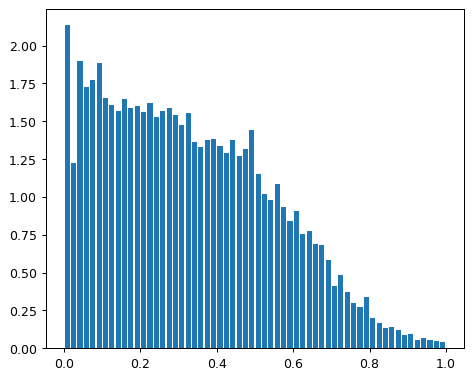

In [193]:
plt.hist(score.flatten(), bins=60, rwidth=.8, density=True);

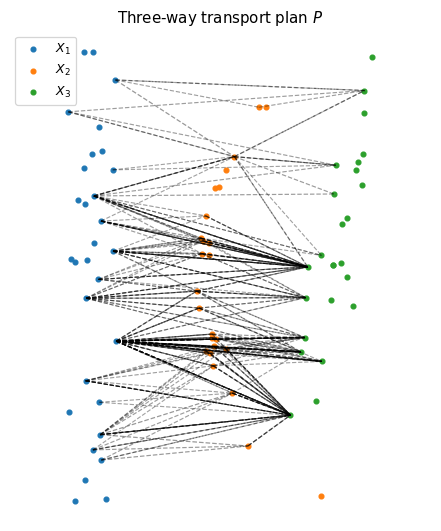

In [200]:
fig = plt.figure(figsize=(5, 6))
s1_ = plt.scatter(*x.T, s=15)
s2_ = plt.scatter(*y.T, s=15)
s3_ = plt.scatter(*z.T, s=15)
plt.legend(["$X_1$", "$X_2$", "$X_3$"])

edge_opts = {
    "zorder": 1,
    "color": "k",
    "ls": "--"
}

## Draw the lines between the datapoints
for i,j,k in index_set:
    alpha = 0.4 * score[i,j,k]
    lw = 1. * score[i,j,k]
    plt.plot((x[i,0], y[j,0]), (x[i,1], y[j,1]),
             **edge_opts,
             alpha=alpha, lw=lw)
    plt.plot((y[j,0], z[k,0]), (y[j,1], z[k,1]),
             **edge_opts,
             alpha=alpha, lw=lw)
    plt.plot((x[i,0], z[k,0]), (x[i,1], z[k,1]),
             **edge_opts,
             alpha=alpha, lw=lw)


plt.axis('equal')
plt.axis('off')
plt.title("Three-way transport plan $P$")
plt.tight_layout();

In [201]:
fig.savefig("../three_way_transport.png", transparent=True)